In [2]:
# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures (adjust path if needed)
PROJECT_ROOT_DIR = "."  # Current directory
IMAGES_DIR = os.path.join(PROJECT_ROOT_DIR, "images")

# create the images directory if it doesn't exist
os.makedirs(IMAGES_DIR, exist_ok=True)

# make sure you use GPU
use_cuda = torch.cuda.is_available() # check for CUDA availability in your machine
device = torch.device("cuda" if use_cuda else "cpu")


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(IMAGES_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

print("Using CUDA ? " + str(use_cuda))



Using CUDA ? True


# Download the FashionMNIST dataset
The dataset consists of 10 classes of clothing items. The training set consists of 60,000 images while the validation set consists of 10,000 images.

In [4]:
import torchvision
import torchvision.transforms as transforms

# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

print(train_set, test_set)

100.0%
100.0%
100.0%
100.0%

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FashionMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## Setup trainloader and testloader for providing the data

In [5]:
# train data uses minibatches of size 32
loader = torch.utils.data.DataLoader(train_set, batch_size=32)

# test data uses a single batch
test_loader = torch.utils.data.DataLoader(test_set)

This gets a single "mini-batch" of samples in the format that your model needs to handle

Batch Input Shape =  torch.Size([32, 1, 28, 28])
Batch Labels Shape =  torch.Size([32])

Example Batch Input =  tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0.,

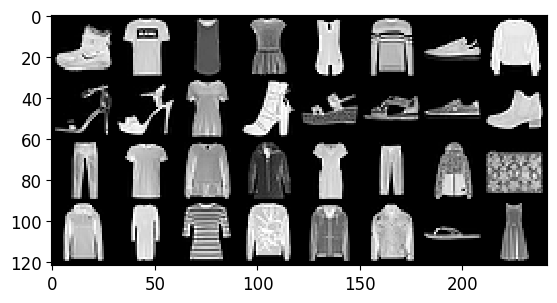

In [6]:
images, labels = next(iter(loader))

print("Batch Input Shape = ",images.shape)
print("Batch Labels Shape = ",labels.shape)
print("")
print("Example Batch Input = ",images)
print("Example Batch Labels = ",labels)
print("")

# show the first batch of training data
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

# Introducing ChaNet, our very efficient CNN model for FashionMNIST

In [8]:

import collections

chanet = nn.Sequential(
    nn.Conv2d(1, 32, 5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32, 64, 5, padding=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.LazyLinear(1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
)

In [9]:
print(chanet)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Dropout(p=0.25, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): LazyLinear(in_features=0, out_features=1024, bias=True)
  (11): ReLU()
  (12): Linear(in_features=1024, out_features=10, bias=True)
)


In [10]:
# test out model before training loop
model_output = chanet(images)
print("Example Model Output = ",model_output)
print("Ground truth batch output = ",labels)

Example Model Output =  tensor([[ 0.1354, -0.0748, -0.4044, -0.4873, -0.4902, -0.1262, -0.0569,  0.1055,
          0.1975,  0.2011],
        [ 0.6697,  0.0675, -0.3542, -0.3709, -0.6033,  0.0861, -0.6097, -0.1762,
          0.3436,  0.2363],
        [ 0.2726,  0.0061, -0.3317, -0.2536, -0.2996,  0.1449, -0.2850,  0.0415,
          0.2294,  0.0588],
        [ 0.3142,  0.0894, -0.4393,  0.1312, -0.4588,  0.1335, -0.2154,  0.1286,
          0.1956,  0.2961],
        [ 0.3713, -0.3042, -0.2149, -0.1332, -0.5375,  0.2123, -0.5005, -0.0444,
          0.0115,  0.2363],
        [ 0.5442, -0.3942, -0.3100, -0.1536, -0.6656,  0.2014, -0.2593, -0.0103,
          0.3480,  0.3288],
        [ 0.2482,  0.0385, -0.1896, -0.4876, -0.4056,  0.0795, -0.3089, -0.2361,
          0.1459,  0.3725],
        [ 0.3569, -0.1045, -0.1729, -0.4654, -0.5877,  0.0595, -0.2791, -0.2557,
          0.1495, -0.0071],
        [-0.2152, -0.0596, -0.3010, -0.2653, -0.2560, -0.3122, -0.2460, -0.0858,
          0.1839,  0.33

In [11]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


## Define optimizer, loss function and learning rate
We are using SGD, but Adam optimizer can also be used. Loss function is Cross Entropy Loss (which uses softmax by default, which is why we dont use it in our network architecture)

In [13]:
lr = 0.01
optimizer = optim.SGD(chanet.parameters(), lr=lr)
#optimizer = optim.Adam(chanet.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()


# Training step

In [14]:
n_epochs = 5 # see how sensitive results are to this


training_loop(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = chanet,
    device = device,
    loss_fn = loss_fn,
    train_loader = loader,
)

2025-02-18 19:22:34.001602 Epoch 1, Training loss 856.0618130862713
2025-02-18 19:22:50.843200 Epoch 2, Training loss 585.7805272005498
2025-02-18 19:23:07.893371 Epoch 3, Training loss 510.2252959497273
2025-02-18 19:23:24.864238 Epoch 4, Training loss 467.6777435205877
2025-02-18 19:23:41.651611 Epoch 5, Training loss 431.60083602555096


# Check accuracy

In [15]:
test_loop(model = chanet, device = device, test_loader = test_loader)


Test set: Average loss: 0.2601, Accuracy: 9063/10000 (91%)

